## 1️⃣ Import Required Libraries

In [1]:
import os
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter, defaultdict
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.2.6
Pandas version: 2.3.2


## 2️⃣ Setup Project Paths

In [2]:
# Get project root directory
project_root = Path.cwd().parent
print(f"📁 Project Root: {project_root}")

# Dataset path
dataset_root = project_root / 'data' / 'zalando-hd-resized'
print(f"📁 Dataset Root: {dataset_root}")

# Check if dataset exists
if not dataset_root.exists():
    print("\n❌ ERROR: Dataset not found!")
    print(f"Expected location: {dataset_root}")
    print("\nPlease ensure the dataset is placed in the correct location.")
else:
    print("\n✅ Dataset found!")
    print(f"\n📂 Dataset contents:")
    for item in sorted(dataset_root.iterdir()):
        print(f"   - {item.name}")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Dataset Root: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized

✅ Dataset found!

📂 Dataset contents:
   - test
   - test_pairs.txt
   - train
   - train_pairs.txt


## 3️⃣ Explore Dataset Structure

In [3]:
def explore_directory_structure(root_path, max_depth=3, current_depth=0, prefix=""):
    """Recursively explore directory structure"""
    if current_depth >= max_depth:
        return
    
    try:
        items = sorted(root_path.iterdir())
        for i, item in enumerate(items):
            is_last = i == len(items) - 1
            current_prefix = "└── " if is_last else "├── "
            
            if item.is_dir():
                # Count files in directory
                try:
                    file_count = len(list(item.glob('*')))
                    print(f"{prefix}{current_prefix}📁 {item.name}/ ({file_count} items)")
                except:
                    print(f"{prefix}{current_prefix}📁 {item.name}/")
                
                # Recurse into subdirectory
                next_prefix = prefix + ("    " if is_last else "│   ")
                explore_directory_structure(item, max_depth, current_depth + 1, next_prefix)
            else:
                # Show file with size
                size_mb = item.stat().st_size / (1024 * 1024)
                if size_mb > 1:
                    print(f"{prefix}{current_prefix}📄 {item.name} ({size_mb:.2f} MB)")
                else:
                    print(f"{prefix}{current_prefix}📄 {item.name}")
    except PermissionError:
        print(f"{prefix}❌ Permission denied")

print("="*70)
print("📂 DATASET STRUCTURE")
print("="*70)
print()
explore_directory_structure(dataset_root, max_depth=3)
print("\n" + "="*70)

📂 DATASET STRUCTURE

├── 📁 test/ (10 items)
│   ├── 📁 agnostic-mask/ (2032 items)
│   │   ├── 📄 00006_00_mask.png
│   │   ├── 📄 00008_00_mask.png
│   │   ├── 📄 00013_00_mask.png
│   │   ├── 📄 00017_00_mask.png
│   │   ├── 📄 00034_00_mask.png
│   │   ├── 📄 00035_00_mask.png
│   │   ├── 📄 00055_00_mask.png
│   │   ├── 📄 00057_00_mask.png
│   │   ├── 📄 00064_00_mask.png
│   │   ├── 📄 00067_00_mask.png
│   │   ├── 📄 00069_00_mask.png
│   │   ├── 📄 00071_00_mask.png
│   │   ├── 📄 00074_00_mask.png
│   │   ├── 📄 00075_00_mask.png
│   │   ├── 📄 00084_00_mask.png
│   │   ├── 📄 00094_00_mask.png
│   │   ├── 📄 00095_00_mask.png
│   │   ├── 📄 00096_00_mask.png
│   │   ├── 📄 00110_00_mask.png
│   │   ├── 📄 00112_00_mask.png
│   │   ├── 📄 00121_00_mask.png
│   │   ├── 📄 00126_00_mask.png
│   │   ├── 📄 00127_00_mask.png
│   │   ├── 📄 00135_00_mask.png
│   │   ├── 📄 00145_00_mask.png
│   │   ├── 📄 00151_00_mask.png
│   │   ├── 📄 00158_00_mask.png
│   │   ├── 📄 00176_00_mask.png
│   │   ├── 📄 00190_00

## 4️⃣ Identify Train and Test Splits

In [4]:
# Find train and test directories
train_dir = dataset_root / 'train'
test_dir = dataset_root / 'test'

print("="*70)
print("📊 DATASET SPLITS")
print("="*70)

splits_found = []

if train_dir.exists():
    print(f"\n✅ Train Split Found: {train_dir}")
    splits_found.append(('train', train_dir))
else:
    print(f"\n❌ Train Split NOT Found: {train_dir}")

if test_dir.exists():
    print(f"✅ Test Split Found: {test_dir}")
    splits_found.append(('test', test_dir))
else:
    print(f"❌ Test Split NOT Found: {test_dir}")

print("\n" + "="*70)

# Store for later use
if not splits_found:
    print("\n⚠️  Warning: No standard train/test splits found.")
    print("Exploring root directory for data...")

📊 DATASET SPLITS

✅ Train Split Found: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized\train
✅ Test Split Found: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized\test



## 5️⃣ Analyze Data Components

In [5]:
def count_files_by_extension(directory):
    """Count files grouped by extension"""
    extensions = defaultdict(int)
    total_size = 0
    
    for file in directory.rglob('*'):
        if file.is_file():
            ext = file.suffix.lower() or 'no_extension'
            extensions[ext] += 1
            total_size += file.stat().st_size
    
    return dict(extensions), total_size

print("="*70)
print("📊 DATA COMPONENT ANALYSIS")
print("="*70)

dataset_stats = {}

for split_name, split_path in splits_found:
    print(f"\n{'='*70}")
    print(f"📁 {split_name.upper()} SPLIT")
    print(f"{'='*70}")
    
    # Check for standard VITON-HD components
    components = {
        'image': split_path / 'image',
        'cloth': split_path / 'cloth',
        'image-parse-v3': split_path / 'image-parse-v3',
        'openpose_img': split_path / 'openpose_img',
        'openpose_json': split_path / 'openpose_json',
    }
    
    split_stats = {}
    
    for component_name, component_path in components.items():
        if component_path.exists():
            file_count = len(list(component_path.glob('*')))
            extensions, total_size = count_files_by_extension(component_path)
            
            split_stats[component_name] = {
                'count': file_count,
                'extensions': extensions,
                'size_mb': total_size / (1024 * 1024)
            }
            
            print(f"\n✅ {component_name:20s}: {file_count:5d} files ({total_size/(1024*1024):.2f} MB)")
            for ext, count in sorted(extensions.items()):
                print(f"   - {ext:15s}: {count:5d} files")
        else:
            print(f"\n❌ {component_name:20s}: NOT FOUND")
            split_stats[component_name] = {'count': 0, 'extensions': {}, 'size_mb': 0}
    
    dataset_stats[split_name] = split_stats

print("\n" + "="*70)

📊 DATA COMPONENT ANALYSIS

📁 TRAIN SPLIT

✅ image               : 11647 files (1474.70 MB)
   - .jpg           : 11647 files

✅ cloth               : 11647 files (1227.72 MB)
   - .jpg           : 11647 files

✅ image-parse-v3      : 11647 files (92.63 MB)
   - .png           : 11647 files

✅ openpose_img        : 11647 files (120.19 MB)
   - .png           : 11647 files

✅ openpose_json       : 11647 files (37.95 MB)
   - .json          : 11647 files

📁 TEST SPLIT

✅ image               :  2032 files (257.07 MB)
   - .jpg           :  2032 files

✅ cloth               :  2032 files (212.83 MB)
   - .jpg           :  2032 files

✅ image-parse-v3      :  2032 files (16.14 MB)
   - .png           :  2032 files

✅ openpose_img        :  2032 files (20.96 MB)
   - .png           :  2032 files

✅ openpose_json       :  2032 files (6.63 MB)
   - .json          :  2032 files



## 6️⃣ Create Summary Statistics Table

In [6]:
# Create summary DataFrame
summary_data = []

for split_name, split_stats in dataset_stats.items():
    for component_name, stats in split_stats.items():
        summary_data.append({
            'Split': split_name.capitalize(),
            'Component': component_name,
            'File Count': stats['count'],
            'Size (MB)': f"{stats['size_mb']:.2f}",
            'Extensions': ', '.join(stats['extensions'].keys()) if stats['extensions'] else 'N/A'
        })

df_summary = pd.DataFrame(summary_data)

print("="*70)
print("📋 DATASET SUMMARY TABLE")
print("="*70)
print()
print(df_summary.to_string(index=False))
print("\n" + "="*70)

# Calculate totals
total_files = df_summary['File Count'].sum()
total_size = df_summary['Size (MB)'].apply(lambda x: float(x)).sum()

print(f"\n📊 Total Files: {total_files:,}")
print(f"📊 Total Size: {total_size:.2f} MB ({total_size/1024:.2f} GB)")

📋 DATASET SUMMARY TABLE

Split      Component  File Count Size (MB) Extensions
Train          image       11647   1474.70       .jpg
Train          cloth       11647   1227.72       .jpg
Train image-parse-v3       11647     92.63       .png
Train   openpose_img       11647    120.19       .png
Train  openpose_json       11647     37.95      .json
 Test          image        2032    257.07       .jpg
 Test          cloth        2032    212.83       .jpg
 Test image-parse-v3        2032     16.14       .png
 Test   openpose_img        2032     20.96       .png
 Test  openpose_json        2032      6.63      .json


📊 Total Files: 68,395
📊 Total Size: 3466.82 MB (3.39 GB)


## 7️⃣ Visualize Dataset Distribution

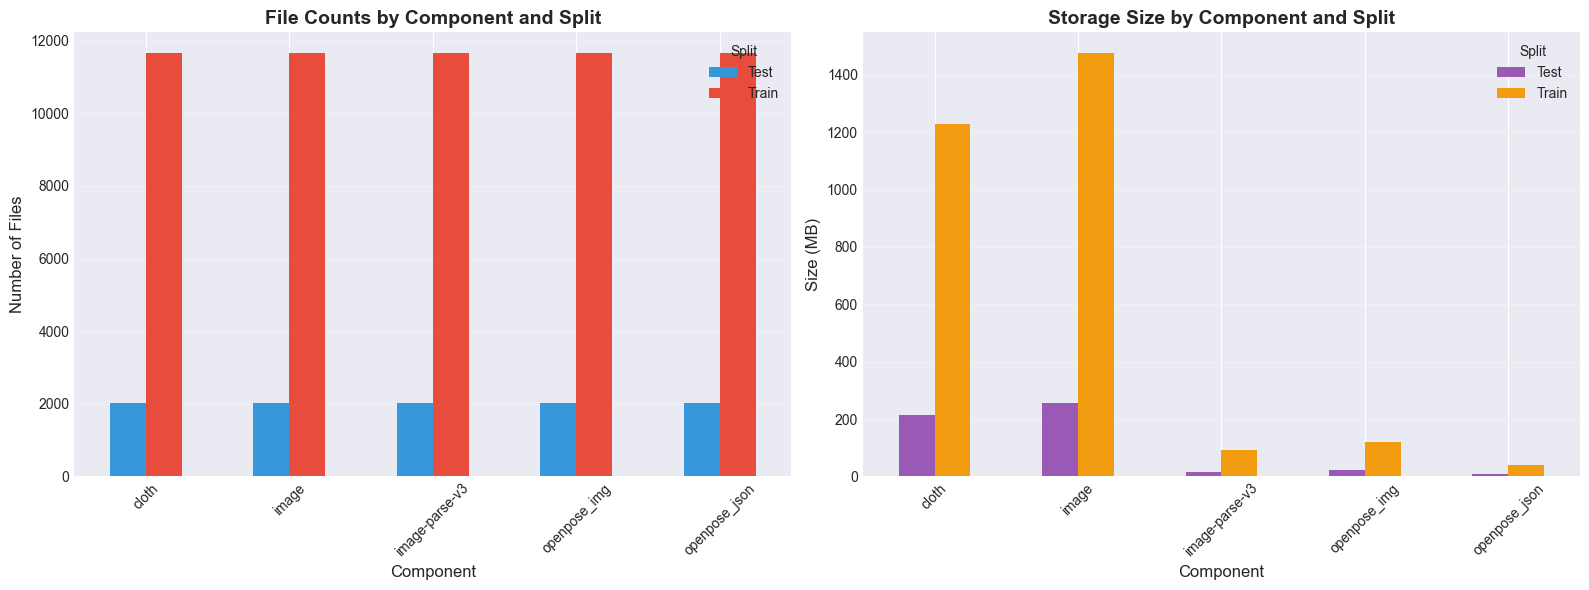

✅ Dataset distribution visualized!


In [7]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: File counts by component
if not df_summary.empty:
    df_pivot = df_summary.pivot(index='Component', columns='Split', values='File Count')
    df_pivot.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
    axes[0].set_title('File Counts by Component and Split', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Component', fontsize=12)
    axes[0].set_ylabel('Number of Files', fontsize=12)
    axes[0].legend(title='Split', fontsize=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Size distribution
    df_summary_copy = df_summary.copy()
    df_summary_copy['Size (MB)'] = df_summary_copy['Size (MB)'].astype(float)
    df_pivot_size = df_summary_copy.pivot(index='Component', columns='Split', values='Size (MB)')
    df_pivot_size.plot(kind='bar', ax=axes[1], color=['#9b59b6', '#f39c12'])
    axes[1].set_title('Storage Size by Component and Split', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Component', fontsize=12)
    axes[1].set_ylabel('Size (MB)', fontsize=12)
    axes[1].legend(title='Split', fontsize=10)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Dataset distribution visualized!")

## 8️⃣ Load Sample Images

In [8]:
def get_random_samples(directory, n=5, extensions=['.jpg', '.png']):
    """Get random sample files from directory"""
    all_files = []
    for ext in extensions:
        all_files.extend(list(directory.glob(f'*{ext}')))
    
    if not all_files:
        return []
    
    n = min(n, len(all_files))
    return np.random.choice(all_files, size=n, replace=False)

# Get sample paths from train split (use first available split if train not found)
sample_split = 'train' if train_dir.exists() else ('test' if test_dir.exists() else None)

if sample_split:
    split_path = train_dir if sample_split == 'train' else test_dir
    
    # Get sample images
    person_images = get_random_samples(split_path / 'image', n=5)
    cloth_images = get_random_samples(split_path / 'cloth', n=5)
    parse_images = get_random_samples(split_path / 'image-parse-v3', n=5) if (split_path / 'image-parse-v3').exists() else []
    pose_images = get_random_samples(split_path / 'openpose_img', n=5) if (split_path / 'openpose_img').exists() else []
    
    print(f"✅ Loaded {len(person_images)} person images")
    print(f"✅ Loaded {len(cloth_images)} cloth images")
    print(f"✅ Loaded {len(parse_images)} parsing masks")
    print(f"✅ Loaded {len(pose_images)} pose visualizations")
else:
    print("❌ No data splits found for sampling")

✅ Loaded 5 person images
✅ Loaded 5 cloth images
✅ Loaded 5 parsing masks
✅ Loaded 5 pose visualizations


## 9️⃣ Visualize Sample Person Images

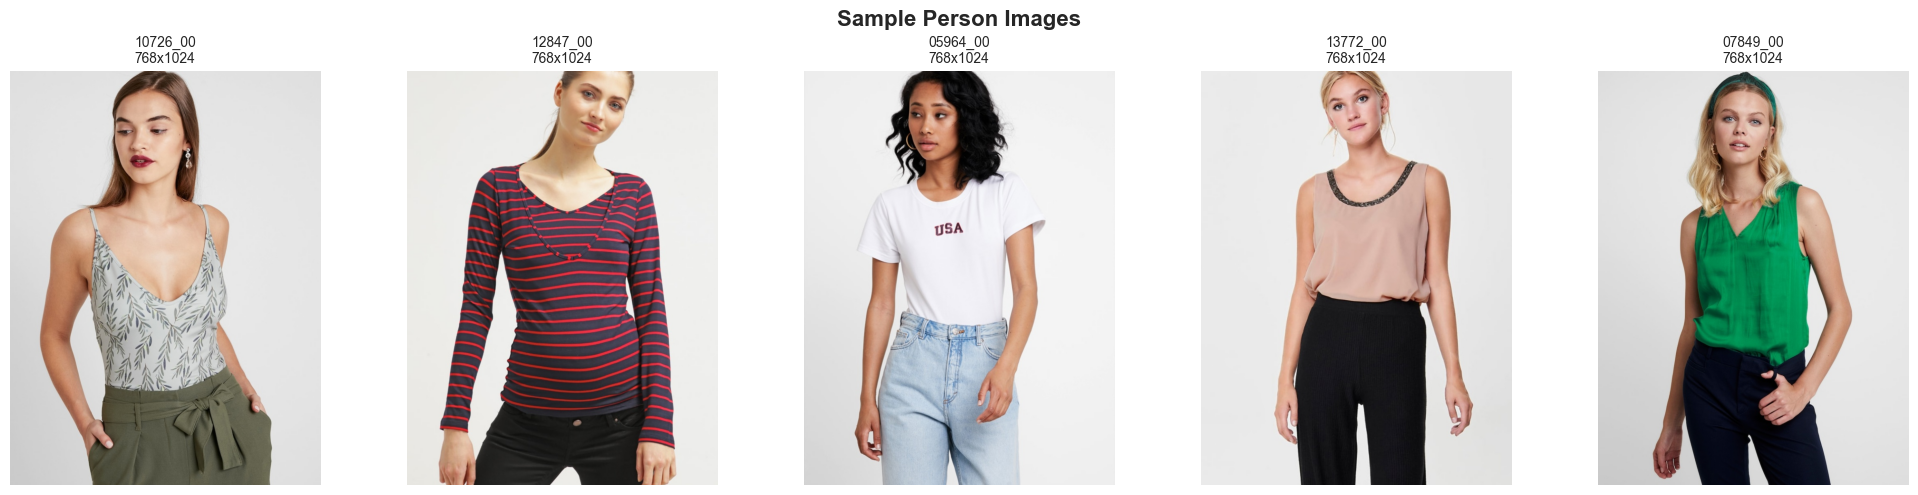

In [10]:
if len(person_images) > 0:
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle('Sample Person Images', fontsize=16, fontweight='bold')
    
    for idx, img_path in enumerate(person_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_path.stem}\n{img.size[0]}x{img.size[1]}", fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No person images found")

## 🔟 Visualize Sample Garment Images

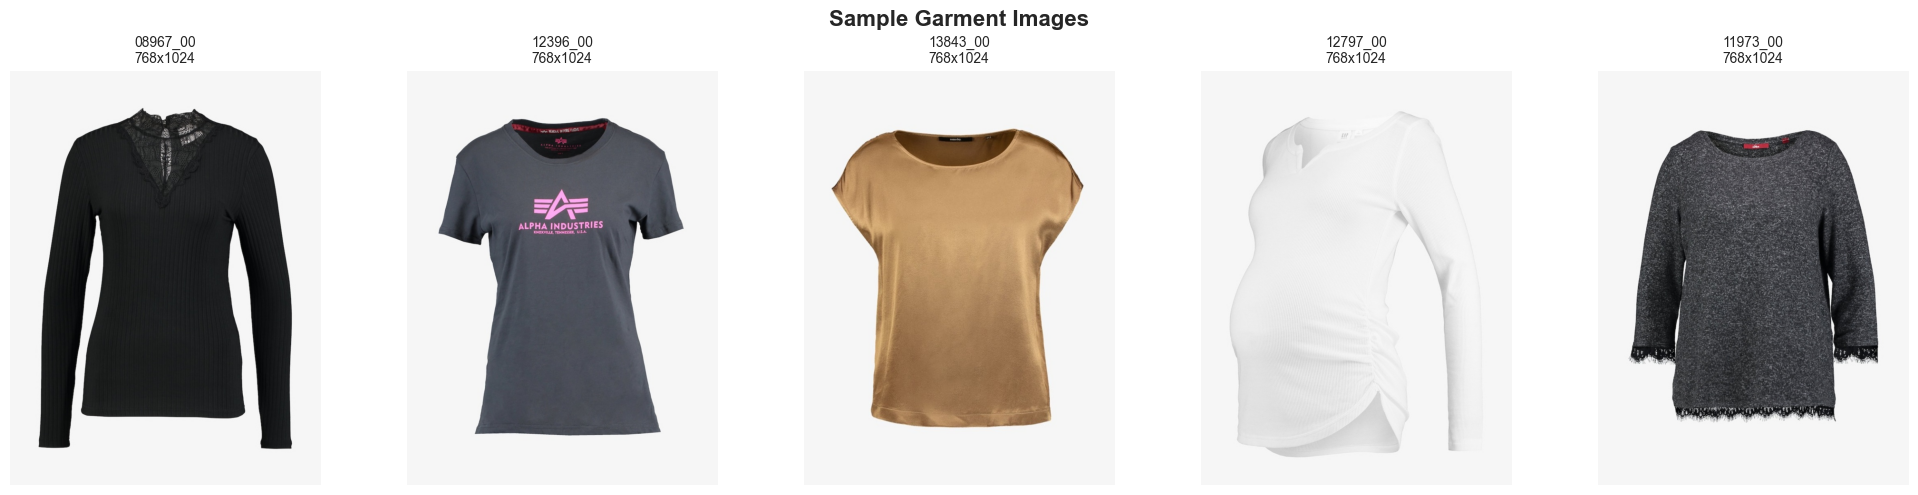

In [11]:
if len(cloth_images) > 0:
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle('Sample Garment Images', fontsize=16, fontweight='bold')
    
    for idx, img_path in enumerate(cloth_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_path.stem}\n{img.size[0]}x{img.size[1]}", fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No garment images found")

## 1️⃣1️⃣ Visualize Segmentation Masks

In [12]:
if len(parse_images) > 0:
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle('Sample Segmentation Masks (Human Parsing)', fontsize=16, fontweight='bold')
    
    for idx, img_path in enumerate(parse_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_path.stem}\n{img.size[0]}x{img.size[1]}", fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No segmentation masks found")

## 1️⃣2️⃣ Visualize Pose Estimations

In [13]:
if len(pose_images) > 0:
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle('Sample Pose Visualizations (OpenPose)', fontsize=16, fontweight='bold')
    
    for idx, img_path in enumerate(pose_images):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_path.stem}\n{img.size[0]}x{img.size[1]}", fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No pose visualizations found")

## 1️⃣3️⃣ Analyze Image Dimensions

In [14]:
def analyze_image_dimensions(directory, sample_size=100):
    """Analyze dimensions of images in directory"""
    image_files = list(directory.glob('*.jpg')) + list(directory.glob('*.png'))
    
    if not image_files:
        return None
    
    # Sample if too many files
    if len(image_files) > sample_size:
        image_files = np.random.choice(image_files, size=sample_size, replace=False)
    
    dimensions = []
    for img_path in image_files:
        try:
            img = Image.open(img_path)
            dimensions.append(img.size)  # (width, height)
        except:
            continue
    
    return dimensions

print("="*70)
print("📐 IMAGE DIMENSION ANALYSIS")
print("="*70)

if sample_split:
    split_path = train_dir if sample_split == 'train' else test_dir
    
    components_to_analyze = [
        ('Person Images', split_path / 'image'),
        ('Garment Images', split_path / 'cloth'),
        ('Parsing Masks', split_path / 'image-parse-v3'),
        ('Pose Images', split_path / 'openpose_img'),
    ]
    
    dimension_stats = {}
    
    for component_name, component_path in components_to_analyze:
        if component_path.exists():
            print(f"\n🔍 Analyzing {component_name}...")
            dims = analyze_image_dimensions(component_path, sample_size=100)
            
            if dims:
                widths = [d[0] for d in dims]
                heights = [d[1] for d in dims]
                
                dimension_stats[component_name] = {
                    'dims': dims,
                    'widths': widths,
                    'heights': heights
                }
                
                print(f"   Samples analyzed: {len(dims)}")
                print(f"   Width:  Min={min(widths):4d}, Max={max(widths):4d}, Mean={np.mean(widths):6.1f}")
                print(f"   Height: Min={min(heights):4d}, Max={max(heights):4d}, Mean={np.mean(heights):6.1f}")
                
                # Check for consistency
                unique_dims = set(dims)
                if len(unique_dims) == 1:
                    print(f"   ✅ All images have consistent dimensions: {dims[0]}")
                else:
                    print(f"   ⚠️  Found {len(unique_dims)} different dimensions")
                    print(f"   Most common: {Counter(dims).most_common(3)}")

print("\n" + "="*70)

📐 IMAGE DIMENSION ANALYSIS

🔍 Analyzing Person Images...
   Samples analyzed: 100
   Width:  Min= 768, Max= 768, Mean= 768.0
   Height: Min=1024, Max=1024, Mean=1024.0
   ✅ All images have consistent dimensions: (768, 1024)

🔍 Analyzing Garment Images...
   Samples analyzed: 100
   Width:  Min= 768, Max= 768, Mean= 768.0
   Height: Min=1024, Max=1024, Mean=1024.0
   ✅ All images have consistent dimensions: (768, 1024)

🔍 Analyzing Parsing Masks...
   Samples analyzed: 100
   Width:  Min= 768, Max= 768, Mean= 768.0
   Height: Min=1024, Max=1024, Mean=1024.0
   ✅ All images have consistent dimensions: (768, 1024)

🔍 Analyzing Pose Images...
   Samples analyzed: 100
   Width:  Min= 768, Max= 768, Mean= 768.0
   Height: Min=1024, Max=1024, Mean=1024.0
   ✅ All images have consistent dimensions: (768, 1024)



## 1️⃣4️⃣ Visualize Dimension Distributions

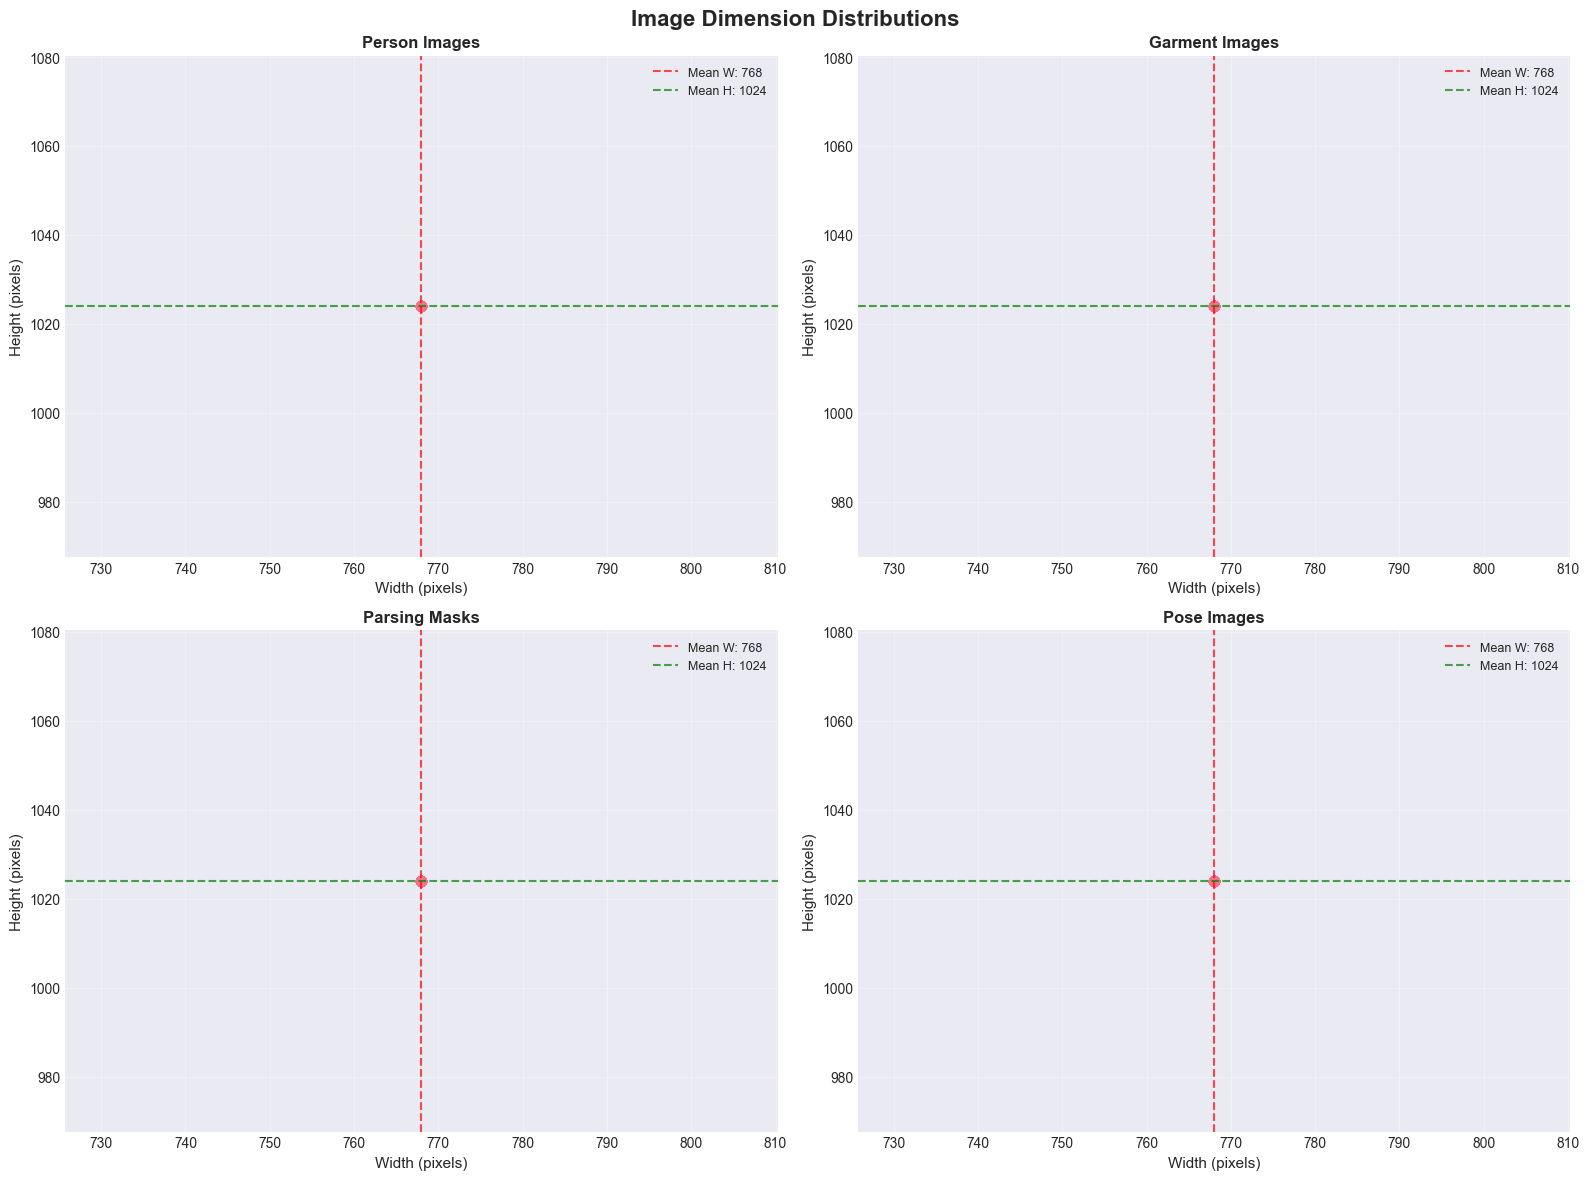

In [15]:
if dimension_stats:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Image Dimension Distributions', fontsize=16, fontweight='bold')
    
    for idx, (component_name, stats) in enumerate(dimension_stats.items()):
        if idx >= 4:  # Only plot first 4 components
            break
        
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        widths = stats['widths']
        heights = stats['heights']
        
        # Scatter plot of width vs height
        ax.scatter(widths, heights, alpha=0.6, s=50)
        ax.set_xlabel('Width (pixels)', fontsize=11)
        ax.set_ylabel('Height (pixels)', fontsize=11)
        ax.set_title(component_name, fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
        
        # Add mean lines
        ax.axvline(np.mean(widths), color='r', linestyle='--', alpha=0.7, label=f'Mean W: {np.mean(widths):.0f}')
        ax.axhline(np.mean(heights), color='g', linestyle='--', alpha=0.7, label=f'Mean H: {np.mean(heights):.0f}')
        ax.legend(fontsize=9)
    
    # Hide unused subplots
    for idx in range(len(dimension_stats), 4):
        row = idx // 2
        col = idx % 2
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No dimension statistics available")

## 1️⃣5️⃣ Analyze Pose JSON Data

In [16]:
if sample_split:
    pose_json_dir = split_path / 'openpose_json'
    
    if pose_json_dir.exists():
        print("="*70)
        print("🦴 POSE JSON ANALYSIS")
        print("="*70)
        
        # Get sample JSON files
        json_files = list(pose_json_dir.glob('*.json'))
        
        if json_files:
            print(f"\n✅ Found {len(json_files)} pose JSON files")
            
            # Load and analyze a sample
            sample_json = json_files[0]
            print(f"\n📄 Sample JSON: {sample_json.name}")
            
            with open(sample_json, 'r') as f:
                pose_data = json.load(f)
            
            print(f"\n📊 JSON Structure:")
            print(f"   Keys: {list(pose_data.keys())}")
            
            if 'people' in pose_data:
                print(f"   Number of people detected: {len(pose_data['people'])}")
                
                if pose_data['people']:
                    person = pose_data['people'][0]
                    print(f"\n   Person data keys: {list(person.keys())}")
                    
                    if 'pose_keypoints_2d' in person:
                        keypoints = person['pose_keypoints_2d']
                        num_keypoints = len(keypoints) // 3  # x, y, confidence for each point
                        print(f"   Number of keypoints: {num_keypoints}")
                        print(f"   Keypoints format: [x, y, confidence] × {num_keypoints}")
                        
                        # Display first few keypoints
                        print(f"\n   Sample keypoints (first 3):")
                        for i in range(min(3, num_keypoints)):
                            x = keypoints[i*3]
                            y = keypoints[i*3 + 1]
                            conf = keypoints[i*3 + 2]
                            print(f"      Point {i}: x={x:.2f}, y={y:.2f}, confidence={conf:.3f}")
            
            print("\n" + "="*70)
        else:
            print("\n❌ No JSON files found in pose directory")
    else:
        print("\n❌ Pose JSON directory not found")

🦴 POSE JSON ANALYSIS

✅ Found 11647 pose JSON files

📄 Sample JSON: 00000_00_keypoints.json

📊 JSON Structure:
   Keys: ['version', 'people']
   Number of people detected: 1

   Person data keys: ['person_id', 'pose_keypoints_2d', 'face_keypoints_2d', 'hand_left_keypoints_2d', 'hand_right_keypoints_2d', 'pose_keypoints_3d', 'face_keypoints_3d', 'hand_left_keypoints_3d', 'hand_right_keypoints_3d']
   Number of keypoints: 25
   Keypoints format: [x, y, confidence] × 25

   Sample keypoints (first 3):
      Point 0: x=377.48, y=144.98, confidence=0.872
      Point 1: x=394.49, y=312.20, confidence=0.746
      Point 2: x=235.63, y=326.40, confidence=0.610



## 1️⃣6️⃣ Create Side-by-Side Comparison

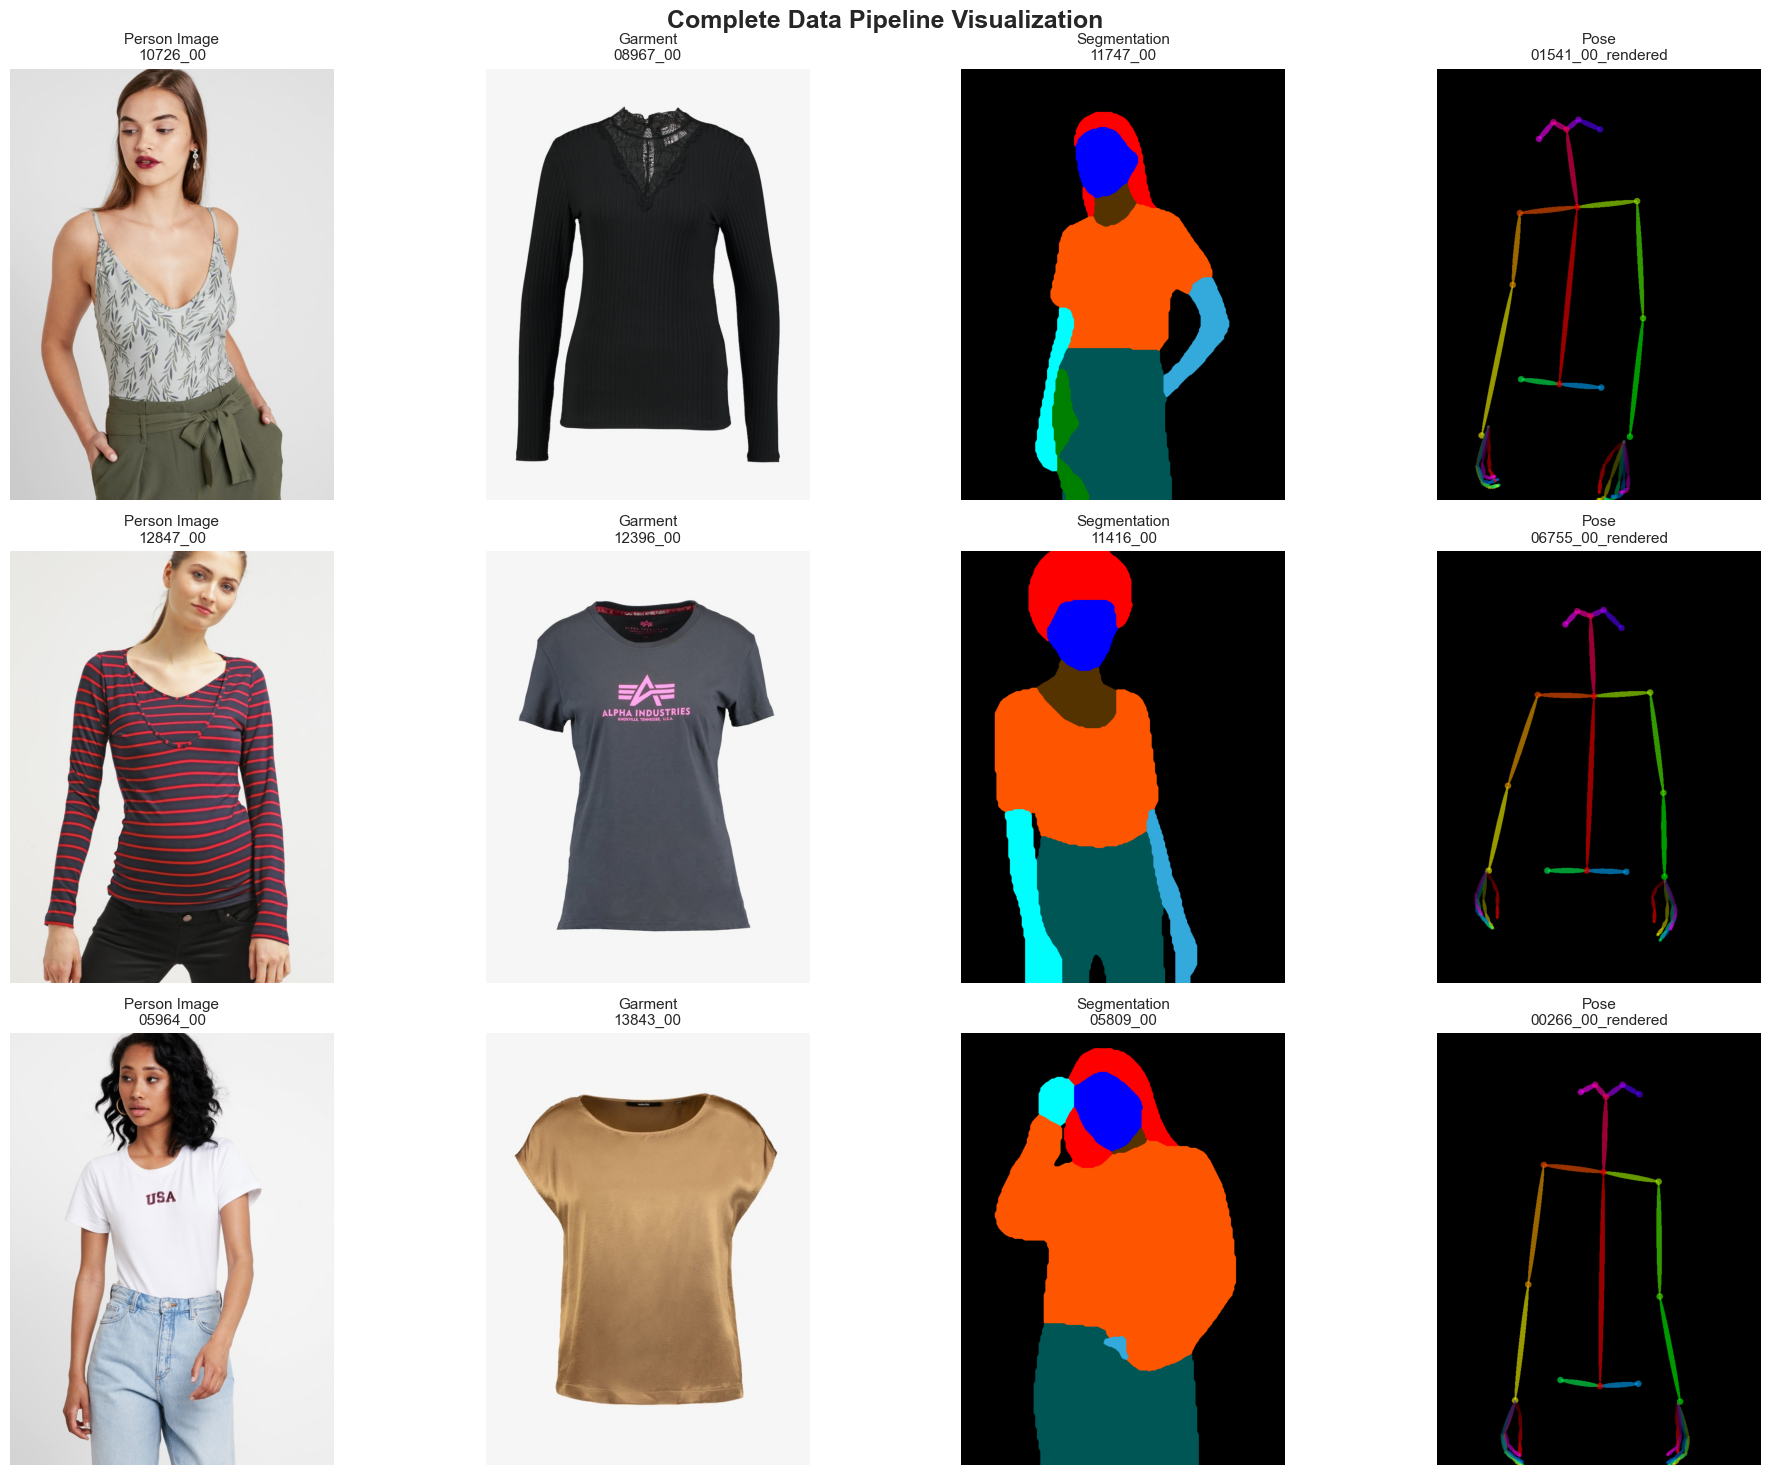

✅ Complete data pipeline visualized!


In [17]:
# Create a comprehensive side-by-side visualization
if len(person_images) > 0 and len(cloth_images) > 0:
    n_samples = 3
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5 * n_samples))
    fig.suptitle('Complete Data Pipeline Visualization', fontsize=18, fontweight='bold')
    
    for i in range(n_samples):
        # Get corresponding files (same index)
        person_path = person_images[i] if i < len(person_images) else person_images[0]
        
        # Load person image
        person_img = Image.open(person_path)
        axes[i, 0].imshow(person_img)
        axes[i, 0].set_title(f'Person Image\n{person_path.stem}', fontsize=11)
        axes[i, 0].axis('off')
        
        # Try to load corresponding cloth
        if i < len(cloth_images):
            cloth_path = cloth_images[i]
            cloth_img = Image.open(cloth_path)
            axes[i, 1].imshow(cloth_img)
            axes[i, 1].set_title(f'Garment\n{cloth_path.stem}', fontsize=11)
        else:
            axes[i, 1].text(0.5, 0.5, 'No Image', ha='center', va='center')
        axes[i, 1].axis('off')
        
        # Try to load corresponding parse mask
        if len(parse_images) > 0 and i < len(parse_images):
            parse_path = parse_images[i]
            parse_img = Image.open(parse_path)
            axes[i, 2].imshow(parse_img)
            axes[i, 2].set_title(f'Segmentation\n{parse_path.stem}', fontsize=11)
        else:
            axes[i, 2].text(0.5, 0.5, 'No Mask', ha='center', va='center')
        axes[i, 2].axis('off')
        
        # Try to load corresponding pose
        if len(pose_images) > 0 and i < len(pose_images):
            pose_path = pose_images[i]
            pose_img = Image.open(pose_path)
            axes[i, 3].imshow(pose_img)
            axes[i, 3].set_title(f'Pose\n{pose_path.stem}', fontsize=11)
        else:
            axes[i, 3].text(0.5, 0.5, 'No Pose', ha='center', va='center')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Complete data pipeline visualized!")
else:
    print("❌ Insufficient data for complete visualization")

## 1️⃣7️⃣ Data Quality Checks

In [18]:
def check_data_integrity(split_path):
    """Check for missing or mismatched data"""
    print("="*70)
    print("🔍 DATA INTEGRITY CHECK")
    print("="*70)
    
    # Get all component directories
    components = {
        'image': split_path / 'image',
        'cloth': split_path / 'cloth',
        'image-parse-v3': split_path / 'image-parse-v3',
        'openpose_img': split_path / 'openpose_img',
        'openpose_json': split_path / 'openpose_json',
    }
    
    # Get filenames (without extensions) from each component
    filenames = {}
    for name, path in components.items():
        if path.exists():
            files = [f.stem for f in path.glob('*') if f.is_file()]
            filenames[name] = set(files)
            print(f"\n✅ {name:20s}: {len(files):5d} files")
        else:
            filenames[name] = set()
            print(f"\n❌ {name:20s}: NOT FOUND")
    
    # Check for consistency
    print(f"\n{'='*70}")
    print("🔗 CONSISTENCY CHECK")
    print(f"{'='*70}")
    
    if filenames['image']:
        base_set = filenames['image']
        print(f"\n📊 Using 'image' as reference: {len(base_set)} files\n")
        
        for name, file_set in filenames.items():
            if name == 'image':
                continue
            
            if file_set:
                missing = base_set - file_set
                extra = file_set - base_set
                matching = len(base_set & file_set)
                
                print(f"{name:20s}:")
                print(f"   ✓ Matching files:  {matching:5d}")
                if missing:
                    print(f"   ⚠ Missing files:   {len(missing):5d}")
                if extra:
                    print(f"   ⚠ Extra files:     {len(extra):5d}")
                if not missing and not extra:
                    print(f"   ✅ Perfect match!")
                print()
    
    print("="*70)
    return filenames

if sample_split:
    integrity_results = check_data_integrity(split_path)
else:
    print("❌ No data split available for integrity check")

🔍 DATA INTEGRITY CHECK

✅ image               : 11647 files

✅ cloth               : 11647 files

✅ image-parse-v3      : 11647 files

✅ openpose_img        : 11647 files

✅ openpose_json       : 11647 files

🔗 CONSISTENCY CHECK

📊 Using 'image' as reference: 11647 files

cloth               :
   ✓ Matching files:  11647
   ✅ Perfect match!

image-parse-v3      :
   ✓ Matching files:  11647
   ✅ Perfect match!

openpose_img        :
   ✓ Matching files:      0
   ⚠ Missing files:   11647
   ⚠ Extra files:     11647

openpose_json       :
   ✓ Matching files:      0
   ⚠ Missing files:   11647
   ⚠ Extra files:     11647



## 1️⃣8️⃣ Key Findings & Insights

In [20]:
print("="*70)
print("💡 KEY FINDINGS & INSIGHTS")
print("="*70)

print("\n📊 Dataset Summary:")
print(f"   - Dataset: Zalando HD Resized (VITON-HD)")
print(f"   - Location: {dataset_root}")
if dataset_stats:
    for split_name, split_stats in dataset_stats.items():
        total_components = sum(1 for s in split_stats.values() if s['count'] > 0)
        print(f"   - {split_name.capitalize()} split: {total_components} components found")

print("\n✅ Data Components Available:")
components_available = []
if len(person_images) > 0:
    components_available.append("Person images")
if len(cloth_images) > 0:
    components_available.append("Garment images")
if len(parse_images) > 0:
    components_available.append("Segmentation masks")
if len(pose_images) > 0:
    components_available.append("Pose visualizations")
if sample_split and (split_path / 'openpose_json').exists():
    components_available.append("Pose JSON keypoints")

for component in components_available:
    print(f"   ✓ {component}")

print("\n📐 Image Dimensions:")
if dimension_stats:
    for component_name, stats in dimension_stats.items():
        mean_w = np.mean(stats['widths'])
        mean_h = np.mean(stats['heights'])
        print(f"   - {component_name}: ~{mean_w:.0f}×{mean_h:.0f} pixels")

print("\n🎯 Recommendations for Preprocessing:")
print("   1. All images should be resized to consistent dimensions (e.g., 512×384 or 1024×768)")
print("   2. Verify person-garment pairing for training")
print("   3. Check segmentation mask quality for body parsing")
print("   4. Validate pose keypoints are correctly detected")
print("   5. Consider data augmentation (flip, rotation, color jitter)")

print("\n🚀 Next Steps:")
print("   1. Proceed to notebook 03_data_preprocessing.ipynb")
print("   2. Create preprocessing pipeline")
print("   3. Generate training/validation/test splits")
print("   4. Set up data loaders for model training")

print("\n" + "="*70)
print("\n✅ DATA EXPLORATION COMPLETE!")
print("="*70)

💡 KEY FINDINGS & INSIGHTS

📊 Dataset Summary:
   - Dataset: Zalando HD Resized (VITON-HD)
   - Location: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized
   - Train split: 5 components found
   - Test split: 5 components found

✅ Data Components Available:
   ✓ Person images
   ✓ Garment images
   ✓ Segmentation masks
   ✓ Pose visualizations
   ✓ Pose JSON keypoints

📐 Image Dimensions:
   - Person Images: ~768×1024 pixels
   - Garment Images: ~768×1024 pixels
   - Parsing Masks: ~768×1024 pixels
   - Pose Images: ~768×1024 pixels

🎯 Recommendations for Preprocessing:
   1. All images should be resized to consistent dimensions (e.g., 512×384 or 1024×768)
   2. Verify person-garment pairing for training
   3. Check segmentation mask quality for body parsing
   4. Validate pose keypoints are correctly detected
   5. Consider data augmentation (flip, rotation, color jitter)

🚀 Next Steps:
   1. Proceed to notebook 03_data_preprocessing.ipynb
   2. Create preprocessing pipeline
   3. 

## 1️⃣9️⃣ Save Exploration Report

In [21]:
# Save exploration report
output_dir = project_root / 'outputs' / 'metrics'
output_dir.mkdir(parents=True, exist_ok=True)

report = {
    'dataset_name': 'Zalando HD Resized (VITON-HD)',
    'dataset_path': str(dataset_root),
    'exploration_date': pd.Timestamp.now().isoformat(),
    'splits': {},
    'components_available': components_available,
}

# Add statistics
for split_name, split_stats in dataset_stats.items():
    report['splits'][split_name] = {
        component: {
            'count': stats['count'],
            'size_mb': stats['size_mb']
        }
        for component, stats in split_stats.items()
    }

# Save as JSON
report_path = output_dir / 'data_exploration_report.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"✅ Exploration report saved to: {report_path}")

# Also save summary DataFrame
if not df_summary.empty:
    csv_path = output_dir / 'data_summary.csv'
    df_summary.to_csv(csv_path, index=False)
    print(f"✅ Summary table saved to: {csv_path}")

✅ Exploration report saved to: d:\Projects\AI-Virtual-TryOn\outputs\metrics\data_exploration_report.json
✅ Summary table saved to: d:\Projects\AI-Virtual-TryOn\outputs\metrics\data_summary.csv


---

## 📝 Notes

### Dataset Structure:

The VITON-HD (Zalando HD Resized) dataset typically contains:
- **Person images**: Full-body fashion model photos
- **Garment images**: Flat-lay or product photos of clothing
- **Segmentation masks**: Human parsing maps (body parts)
- **Pose keypoints**: OpenPose format with body joint locations

### Key Observations:

1. **Image Quality**: Check if images are consistent in quality and resolution
2. **Pose Variety**: Dataset should include diverse poses for robustness
3. **Garment Types**: Variety of clothing types (shirts, dresses, etc.)
4. **Data Completeness**: All components should have matching files

### Common Issues:

- **Missing Pairs**: Some person-garment pairs might be missing
- **Inconsistent Dimensions**: Images may have different sizes
- **Corrupted Files**: Some images might be unreadable
- **Pose Detection Errors**: Some pose keypoints might be incorrect

### Preprocessing Requirements:

1. Resize all images to consistent dimensions
2. Normalize pixel values
3. Validate segmentation masks
4. Filter out invalid pose detections
5. Create train/validation/test splits

---

## 🔗 Useful Resources

- [VITON-HD Paper](https://arxiv.org/abs/2103.16874)
- [VITON-HD GitHub](https://github.com/shadow2496/VITON-HD)
- [OpenPose Format](https://github.com/CMU-Perceptual-Computing-Lab/openpose)
- [Human Parsing](https://github.com/GoGoDuck912/Self-Correction-Human-Parsing)

---

**Author**: Huzaifa Nasir  
**Date**: December 2025  
**Notebook**: 02_data_exploration.ipynb  
**Status**: ✅ Complete